In [1]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis
Clean the dataset and find seasonalities

In [3]:
df = pd.read_csv('MTA_Subway_Ridership_Data_Clean.csv')
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.set_index("Date", inplace=True)
df.rename(columns={
    "Subways: Total Estimated Ridership" : "Total Ridership",
    "Subways: % of Comparable Pre-Pandemic Day" : "Pre-Pandemic Ridership"
}, inplace=True)

In [4]:
df.head()

,Total Ridership,Pre-Pandemic Ridership
Date,,
2020-03-01,2212965,0.97
2020-03-02,5329915,0.96
2020-03-03,5481103,0.98
2020-03-04,5498809,0.99
2020-03-05,5496453,0.99


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

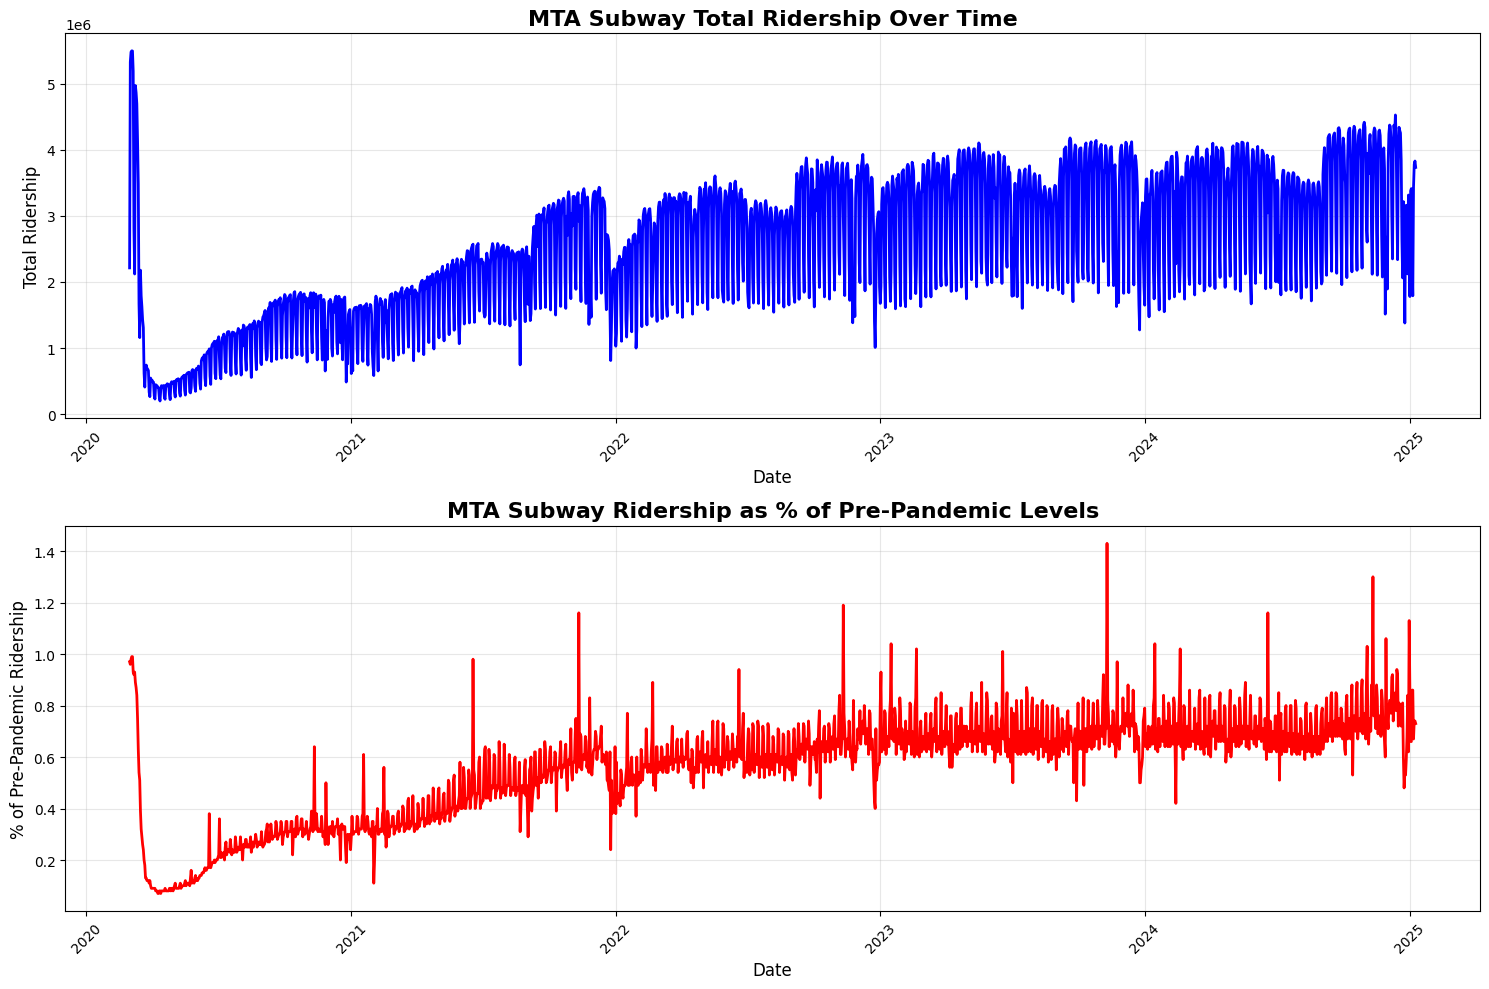

In [7]:
# Plot the ridership data
plt.figure(figsize=(15, 10))

# Plot 1: Total Ridership over time
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Total Ridership'], linewidth=2, color='blue')
plt.title('MTA Subway Total Ridership Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Ridership', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Pre-Pandemic Ridership percentage over time
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Pre-Pandemic Ridership'], linewidth=2, color='red')
plt.title('MTA Subway Ridership as % of Pre-Pandemic Levels', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('% of Pre-Pandemic Ridership', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


From the plots above, we can see that there are yearly seasonalities, in addition to weekly seasonalities. Also, the year `2020` is an outlier because of the COVID pandemic. We will now see if the Box-Cox transform is needed

In [8]:
from scipy.stats import boxcox

_, LAMBDA = boxcox(df['Total Ridership'].values)
print(f"Estimated LAMBDA: {LAMBDA}")

Estimated LAMBDA: 0.9725707831410361


We see $\lambda \approx 0.9726$ which is very close to $1$, so the transform is not needed.